# Injection

In [1]:
from math import exp
import numpy
import neo
from quantities import ms
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.utility.plotting import DataTable
from pyNN.parameters import Sequence
from importlib import import_module

In [2]:
op_simulator = "neuron"
op_debug = False
op_dendritic_delay_fraction = False
op_fit_curve = False
op_plot_figure = True

min_delay = 0.01
max_delay = 0.1
num_neurons = 10

In [3]:
firing_period = 10.0    # (ms) interval between spikes
cell_parameters = {
    "tau_m": 10.0,       # (ms)
    "v_thresh": -50.0,   # (mV)
    "v_reset": -60.0,    # (mV)
    "v_rest": -60.0,     # (mV)
    "cm": 1.0,           # (nF)
    "tau_refrac": firing_period / 2,  # (ms) long refractory period to prevent bursting
}

n_neurons = 784                  # number of synapses / number of presynaptic neurons
bach_size = 2
sample_period = 100 # (ms) for each img sample
simulate_time = bach_size * sample_period # regard as
spike_thresh = 0.3 # when image pixel value greater than spike_thresh
delay = 0.01              # (ms) synaptic time delay, default=3.0

In [4]:
sim = import_module("pyNN."+op_simulator)

if op_debug: 
    init_logging(None, debug=True)

sim.setup(timestep=0.01, min_delay=min_delay, max_delay=max_delay)

0

In [5]:
# DEFINING TESTSET
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from data_handler import *

In [6]:
# Load MNIST data
print "loading MNIST data..."
dh = DataHandler(randseed=19023895)
dh.load_data()
dh.shuffle_data()
train_data, train_label, test_data, test_label, train_one_hot, test_one_hot = dh.get_data_nparray()
# dh.display_ID('train', 2)
print "loaded!"

loading MNIST data...
data loading from pickle...
loaded!


In [7]:
# generate spike table
print "generating spike table..."
init_test_img_spike_table, test_img_spike_table = generateDataMaskedSpikes(data=test_data,
                                                                             sample_period=sample_period,
                                                                             firing_period=firing_period,
                                                                             thresh=spike_thresh)
#spike_tabel = generatePoissonSpikes(t_stop = t_stop, n_neurons = n_neurons, period = firing_period)
img_spike_sequence_generator = build_spike_sequences(test_img_spike_table)

generating spike table...
n_samples =  10000
n_neurons =  784
t_stop =  1000000
generate random poisson spikes...
generate poisson spike till 10006.3 in 1000000.0 : 1.001 %
generate poisson spike till 20018.5 in 1000000.0 : 2.002 %
generate poisson spike till 30023.6 in 1000000.0 : 3.002 %
generate poisson spike till 40005.9 in 1000000.0 : 4.001 %
generate poisson spike till 50002.3 in 1000000.0 : 5.000 %
generate poisson spike till 60001.1 in 1000000.0 : 6.000 %
generate poisson spike till 70008.8 in 1000000.0 : 7.001 %
generate poisson spike till 80006.3 in 1000000.0 : 8.001 %
generate poisson spike till 90008.9 in 1000000.0 : 9.001 %
generate poisson spike till 100006.8 in 1000000.0 : 10.001 %
generate poisson spike till 110007.7 in 1000000.0 : 11.001 %
generate poisson spike till 120004.6 in 1000000.0 : 12.000 %
generate poisson spike till 130005.4 in 1000000.0 : 13.001 %
generate poisson spike till 140012.1 in 1000000.0 : 14.001 %
generate poisson spike till 150002.8 in 1000000.0 

'\ninit_test_lab_spike_table, test_lab_spike_table = generateDataMaskedSpikes(data=test_one_hot,\n                                                                             sample_period=sample_period,\n                                                                             firing_period=firing_period)\n#lab_spike_sequence_generator = build_spike_sequences(test_img_spike_table)\n'

In [8]:
# presynaptic population
print "buildup neural network"
p_in = sim.Population(n_neurons, sim.SpikeSourceArray(spike_times=img_spike_sequence_generator),
                    label="presynaptic")
p_mid_1 = sim.Population(n_neurons, sim.IF_cond_exp(**cell_parameters),
                    initial_values={"v": cell_parameters["v_reset"]}, label="postsynaptic_1")

stdp_model = sim.STDPMechanism(
                timing_dependence=sim.SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                                    A_plus=0.01, A_minus=0.012),
                weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=0.0000001),
                weight=0.00000005,
                delay=delay,
                dendritic_delay_fraction=float(op_dendritic_delay_fraction))
connections_1 = sim.Projection(p_in, p_mid_1, sim.OneToOneConnector(), 
                               sim.StaticSynapse(weight=10.0, delay=delay))

buildup neural network


In [9]:
p_in.record('spikes')
p_mid_1.record(['spikes', 'v'])

In [10]:
sim.run(simulate_time)

199.9999999998906

In [11]:
presynaptic_data = p_in.get_data().segments[0]
postsynaptic_data_1 = p_mid_1.get_data().segments[0]
print("Post-synaptic 1 spike times: %s" % postsynaptic_data_1.spiketrains[0])

Post-synaptic 1 spike times: [2.000e-02 5.030e+00 1.004e+01 1.505e+01 2.006e+01 2.507e+01 3.008e+01
 3.509e+01 4.010e+01 4.511e+01 5.012e+01 5.514e+01 6.019e+01 6.531e+01
 7.065e+01 7.674e+01] ms


In [ ]:
#plotNeuronsSpikes(test_img_spike_table)
filename = normalized_filename("Results", "my_stdp", "pkl", op_simulator)
if op_plot_figure:
    from pyNN.utility.plotting import Figure, Panel, DataTable
    figure_filename = filename.replace("pkl", "png")
    Figure(
        # raster plot of the presynaptic neuron spike times
        Panel(presynaptic_data.spiketrains,
              yticks=True, markersize=0.2, xlim=(0, simulate_time)),
        # membrane potential of the postsynaptic neuron 1
        Panel(postsynaptic_data_1.filter(name='v')[0],
              ylabel="Membrane-1 potential (mV)",
              data_labels=[p_mid_1.label], yticks=True, xlim=(0, simulate_time)),
        title="MY - STDP",
        annotations="Simulated with %s" % op_simulator.upper(),
        size = (16,8)
    )

In [12]:
# === Clean up and quit ========================================================
sim.end()

# Data Handler

In [31]:
%matplotlib inline
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

class DataHandler:
    '''
        mnist data downloaded from 'https://www.python-course.eu/neural_network_mnist.php'
    '''
    
    def __init__(self, randseed = 20181121, MNIST_data_path = '/home/janilbols/Code/data/mnist/', 
                 image_size = 28, no_of_different_labels = 10):        
        self.randseed = randseed
        self.data_path = MNIST_data_path
        self.image_size = image_size # width and length
        self.no_of_different_labels = no_of_different_labels #  i.e. 0, 1, 2, 3, ..., 9
        self.image_pixels = image_size * image_size
        
        self.train_data = np.array([])
        self.train_label = np.array([])
        self.train_label_one_hot = np.array([])
        self.test_data = np.array([])
        self.test_label = np.array([])
        self.test_label_one_hot = np.array([])
        self.shuffle_train_order = np.array([])
        self.shuffle_test_order = np.array([])
        
    def load_data(self, flag_From_Pickle = True, flag_normalize = False, flag_Debug = True):
        ''' 
            Load MNIST data from MNIST_data_path
            
            Flags:
            - flag_From_Pickle: try to load data from pickle file, else from csv
            - flag_normalize: load data from csv, with normalization
            - flag_Debug: print some debug message
            
            Logic:            
            - If failed, return false
              Else return true
        '''
        flag_okay = False
        
        #-- Load from pickle -------------------------------------------------------
        if flag_From_Pickle:
            if not(os.path.isfile("%s" % self.data_path + "pickled_mnist.pkl")):
                print("File not found:%s" % self.data_path + "pickled_mnist.pkl")
                print("solution: Try open with csv file")
            else:
                if flag_Debug:
                    print("data loading from pickle...")
                with open("%s" % self.data_path + "pickled_mnist.pkl", "r") as fh:
                    data = pickle.load(fh)
                self.train_data = data[0]
                self.test_data = data[1]
                self.train_label = data[2]
                self.test_label = data[3]
                self.train_label_one_hot = data[4]
                self.test_label_one_hot = data[5]
                flag_okay = True
                return flag_okay

        #-- Load from csv file -----------------------------------------------------   
        if not(os.path.isfile('%s' % self.data_path + "mnist_train.csv")):
            print("File not found:%s" % self.data_path + "mnist_train.csv")
            flag_okay = False
            return flag_okay
        if not(os.path.isfile('%s' % self.data_path + "mnist_train.csv")):
            print("File not found:%s" % self.data_path + "mnist_train.csv")
            if_okay = False
            return flag_okay
        
        if flag_Debug:
            print("Data Loading: Train")
        train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
        if flag_Debug:
            print("Data Loading: Test")
        test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 
        if flag_Debug:
            print("Data Normalizing: transfer into [0,1]")
        fac = 255  *0.99 + 0.01
        self.train_data = np.asfarray(train_data[:, 1:]) / fac 
        self.test_data = np.asfarray(test_data[:, 1:]) / fac 
        self.train_label = np.asfarray(train_data[:, :1]) 
        self.test_label = np.asfarray(test_data[:, :1]) 
        
        lr = np.arange(no_of_different_labels)
        # transform labels into one hot representation
        train_label_one_hot = (lr==train_labels).astype(np.float)
        train_label_one_hot = (lr==test_labels).astype(np.float)
        # we don't want zeroes and ones in the labels neither:
        
        if flag_normalize:
            train_label_one_hot[train_label_one_hot==0] = 0.01
            train_label_one_hot[train_label_one_hot==1] = 0.99
            test_label_one_hot[test_label_one_hot==0] = 0.01
            test_label_one_hot[test_label_one_hot==1] = 0.99

        self.train_label_one_hot = train_label_one_hot
        self.test_label_one_hot = test_label_one_hot
        
        flag_okay = True
        return flag_okay
    
    def shuffle_data(self):
        self.shuffle_train_order = np.arange(len(self.train_data))
        self.shuffle_test_order = np.arange(len(self.test_data))
        np.random.seed(self.randseed)
        np.random.shuffle(self.shuffle_train_order)
        np.random.seed(self.randseed)
        np.random.shuffle(self.shuffle_test_order)
        
        self.train_data = self.train_data[self.shuffle_train_order] 
        self.train_label = self.train_label[self.shuffle_train_order]
        self.test_data = self.test_data[self.shuffle_test_order]
        self.test_label = self.test_label[self.shuffle_test_order]
        self.train_label_one_hot = self.train_label_one_hot[self.shuffle_train_order]
        self.test_label_one_hot = self.test_label_one_hot[self.shuffle_test_order]
        return True
        
    def get_data_nparray(self):
        return [self.train_data, self.train_label, 
                self.test_data, self.test_label, 
                self.train_label_one_hot, self.test_label_one_hot]


    def display_ID(self, data_type ='train', data_id=0):
        if data_type == 'train':
            if len(self.train_data)<=data_id:
                print("Data-ID not found in Train-set!")
                return False
            img = self.train_data[data_id]
            label = self.train_label[data_id]
            one_hot = self.train_label_one_hot
        elif data_type == 'test':
            if len(self.test_data)<=data_id:
                print("Data-ID not found in Test-set!")
                return False
            img = self.test_data[data_id]
            label = self.test_label[data_id]
            one_hot = self.test_label_one_hot
        else:
            print("Unknown Data Type!")
            return False
        img = img.reshape((28,28))
        plt.imshow(img, cmap="Greys")
        plt.show()
        print(label)
        print(one_hot)
        
        return True

In [106]:
dh = DataHandler()
dh.load_data()
dh.shuffle_data()
train_data, train_label, test_data, test_label, train_one_hot, test_one_hot = dh.get_data_nparray()
dh.display_ID('train', 2)

NameError: name 'DataHandler' is not defined

# TEST INJECTION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from data_handler import *

import time

In [2]:
sample_period = 0.1
firing_period = 0.005
spike_thresh = 0.3

In [3]:
dh = DataHandler(randseed=19023895)
dh.load_data()
dh.shuffle_data()
train_data, train_label, test_data, test_label, train_one_hot, test_one_hot = dh.get_data_nparray()

data loading from pickle...


In [4]:
init_test_in, test_in = generateDataMaskedSpikes(data=test_data,
                                                 sample_period=sample_period,
                                                 firing_period=firing_period,
                                                 thresh=spike_thresh)
init_test_out, test_out = generateDataMaskedSpikes(data=test_one_hot,
                                                 sample_period=sample_period,
                                                 firing_period=firing_period,
                                                 thresh=spike_thresh)

n_samples =  10000
n_neurons =  784
t_stop =  1000.0
sample_period =  0.1
firing_period =  0.005
generate random poisson spikes...
generate poisson spike till 50.0 in 1000.0 : 5.000 %
generate poisson spike till 100.0 in 1000.0 : 10.000 %
generate poisson spike till 150.0 in 1000.0 : 15.000 %
generate poisson spike till 200.0 in 1000.0 : 20.000 %
generate poisson spike till 250.0 in 1000.0 : 25.000 %
generate poisson spike till 300.0 in 1000.0 : 30.000 %
generate poisson spike till 350.0 in 1000.0 : 35.001 %
generate poisson spike till 400.0 in 1000.0 : 40.001 %
generate poisson spike till 450.0 in 1000.0 : 45.000 %
generate poisson spike till 500.0 in 1000.0 : 50.000 %
generate poisson spike till 550.0 in 1000.0 : 55.000 %
generate poisson spike till 600.0 in 1000.0 : 60.000 %
generate poisson spike till 650.0 in 1000.0 : 65.000 %
generate poisson spike till 700.0 in 1000.0 : 70.001 %
generate poisson spike till 750.0 in 1000.0 : 75.000 %
generate poisson spike till 800.0 in 1000.0 : 

In [26]:
np.shape(test_out)
np.shape(test_in)

(784, 146673)

(784, 200)
(10, 200)


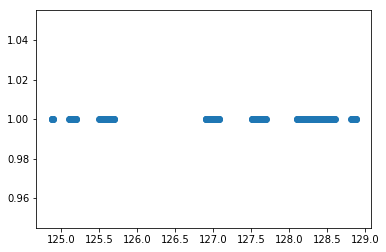

In [54]:
## plot_temp_in = test_in[:,start:start+k]
plot_temp_out = test_out[:,start:start+k]
print np.shape(plot_temp_in)
print np.shape(plot_temp_out)

plt.plot( plot_temp_in[292], np.ones(np.shape(plot_temp_in)[1]),  'o')

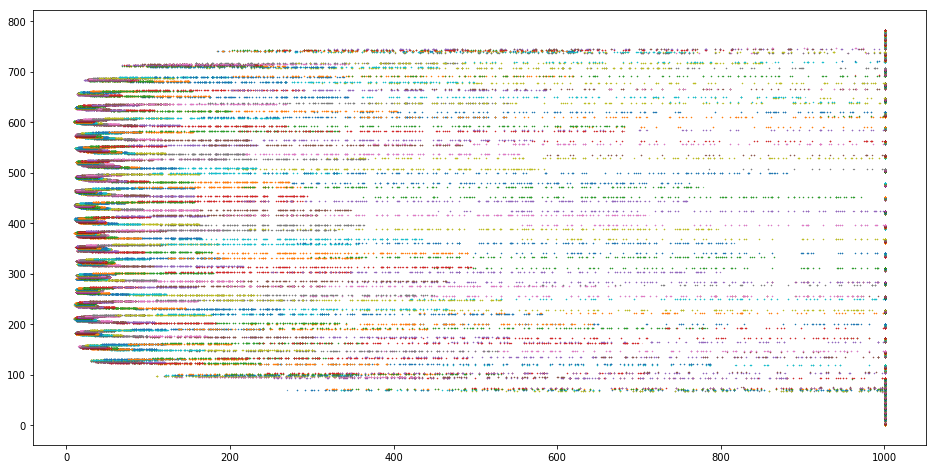

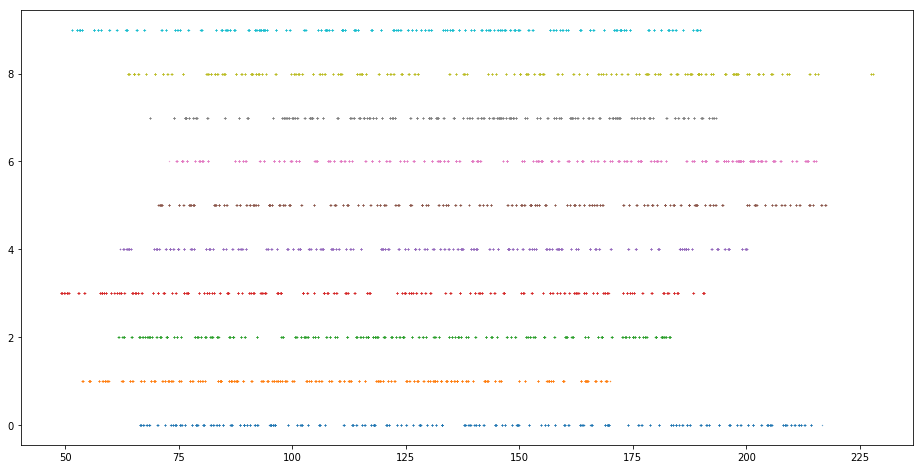

In [58]:
start = 898
k = 2000
plot_temp_in = test_in[:,start:start+k]
plot_temp_out = test_out[:,start:start+k]
figure = plt.figure(figsize=(16,8))
for i in range(np.shape(plot_temp_in)[0]):
    plt.plot(plot_temp_in[i],np.ones(np.shape(plot_temp_in)[1])*i,'o', markersize=0.1, alpha=1)
figure = plt.figure(figsize=(16,8))
for i in range(np.shape(plot_temp_out)[0]):
    plt.plot(plot_temp_out[i],np.ones(np.shape(plot_temp_out)[1])*i,'o', markersize=0.3, alpha=1)
    